# Compare Delta Y vs G - I

- Focus on PWV

- author : Sylvie Dagoret
- affiliation : LAL/IN2P3/CNRS
- creation date : October 15th 2018
- update : October 15th 2018



In [335]:
import pandas as pd
import numpy as np
import os,sys
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt
from astropy.io import fits
%matplotlib inline
from scipy.interpolate import interp1d

In [336]:
from astropy.io import fits

In [337]:
from lsst.sims.photUtils import SignalToNoise
from lsst.sims.photUtils import PhotometricParameters
from lsst.sims.photUtils import Bandpass,Sed

In [338]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [339]:
import matplotlib.colors as colors
import matplotlib.cm as cmx

In [340]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (14, 10),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

In [341]:
PATH_LIBRADTRAN='./librandtran'
PATH_MODTRAN='./modtran'
PATH_MYLSSTSIMS='./lsst_sims'

In [342]:
sys.path.append(PATH_LIBRADTRAN)
sys.path.append(PATH_MODTRAN)
sys.path.append(PATH_MYLSSTSIMS)

In [343]:
import libReadModtran as mt
import libsimulateTranspLSSTScattAbsAer3 as rt

In [344]:
from MyTelescope import *
from MyThroughputs import *

In [345]:
def plot_sedimg(data,index_spec):
    plt.figure(figsize=(15,10))   
    img=plt.imshow(data[1:,index_spec:],origin='lower',cmap='jet')
    plt.colorbar(img)
    plt.grid(True)
    plt.title('sed grid')
    plt.xlabel('bin number of wavelengths')
    plt.ylabel('sed number')
    plt.show()

In [346]:
def plot_allsed(data,index_spec):
    plt.figure()   
    
    for idx in np.arange(data.shape[0]-1):
      
        plt.semilogy(data[0,index_spec:],data[1+idx,index_spec:],'-')
    plt.grid(True)
    plt.title('sed')
    plt.xlabel('wavelength (A)')
    plt.ylabel('sed (flam)')
    plt.show()

# Config

In [347]:
#------------------------------------------------------------------------
# Definition of data format for the atmospheric grid
#-----------------------------------------------------------------------------
WLMIN=250.  # Minimum wavelength : PySynPhot works with Angstrom
WLMAX=1151. # Minimum wavelength : PySynPhot works with Angstrom
WL=np.arange(WLMIN,WLMAX,1) # Array of wavelength in Angstrom
NBWL=len(WL)


In [348]:
## Config LSST

In [349]:
all_filternum = {'u':1, 'g':2, 'r':3, 'i':4, 'z':5, 'y':6}

In [350]:
LSST_SkyBrightness=np.array([22.03,21.68,21.02,19.7,17.83,17.21])

In [351]:
LSST_GeomSeeing=np.array([1.1,1.02,0.95,0.92,0.88,0.94])

# Configuration of input SED

In [352]:
sed_file="regenerated_sedgrid_pickle_uvk.fits"

In [353]:
sed_hdu = fits.open(sed_file)

In [354]:
theheader=sed_hdu[0].header
theheader

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 8515                                                  
NAXIS2  =                12963                                                  
NBSED   =                12962                                                  
NBWLBIN =                 8510                                                  
WLMIN   =               3000.0                                                  
WLMAX   =              11510.0                                                  
WLBINWDT=                  1.0                                                  
SEDUNIT = 'FLAM    '                                                            
SEDMODEL= 'pickle_uvk'                                                          
IDX_NUM =                   

In [355]:
sidx_num=theheader['IDX_NUM']
sidx_val=theheader['IDX_VAL']
sidx_sed=theheader['IDX_SED']
sidx_data=theheader['IDX_DATA']
sidx_spec=theheader['IDX_SPEC']

In [356]:
sed_data=sed_hdu[0].data

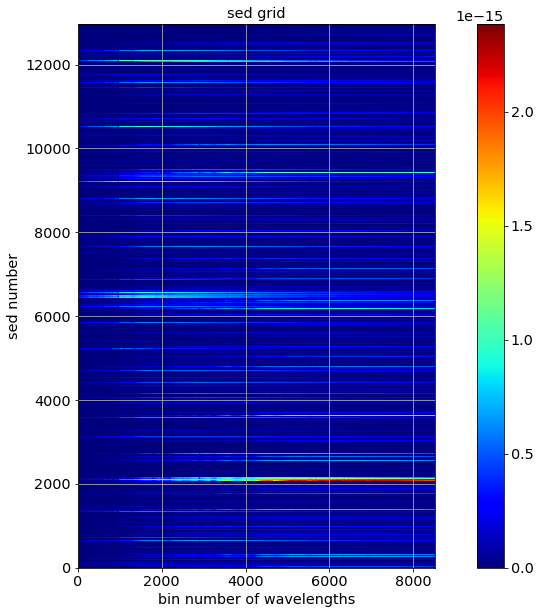

In [357]:
plot_sedimg(sed_data,sidx_spec)

In [358]:
#plot_allsed(sed_data,sidx_spec)

In [359]:
NBSED_MAX=sed_data.shape[0]-1

In [360]:
NBSED_MAX

12962

## Config for Modtran

In [361]:
path_modtrandata='modtrandata/Jul6th2018'

In [362]:
def GetModtranFilenames():
    files_data = [f for f in listdir(path_modtrandata) if isfile(join(path_modtrandata, f))]
    files_data.sort()
    
    # select reduced files
    files_selected=[]
    for file in files_data:
        if file.find("_reduced")==-1:
            print("reject ",file)
        else:
            files_selected.append(file)
            
    files_selected.sort()
    return files_selected


In [363]:
def GetAirmassFromModtranFilename(filename):
    splitted_filename=filename.split('.')
    tagname=splitted_filename[1]
    airmass_str=tagname.split('_')[0]
    am=float(airmass_str)/10.
    return am
    

In [364]:
files_modtran=GetModtranFilenames()

reject  Pachon_MODTRAN.10.7sc
reject  Pachon_MODTRAN.11.7sc
reject  Pachon_MODTRAN.12.7sc
reject  Pachon_MODTRAN.13.7sc
reject  Pachon_MODTRAN.14.7sc
reject  Pachon_MODTRAN.15.txt
reject  Pachon_MODTRAN.16.7sc
reject  Pachon_MODTRAN.17.7sc
reject  Pachon_MODTRAN.18.7sc
reject  Pachon_MODTRAN.19.7sc
reject  Pachon_MODTRAN.20.7sc
reject  Pachon_MODTRAN.21.7sc
reject  Pachon_MODTRAN.22.7sc
reject  Pachon_MODTRAN.23.7sc
reject  Pachon_MODTRAN.25.7sc
reject  Pachon_MODTRAN.7sc


In [365]:
NBMTFILES=len(files_modtran)-1

### Get all all available Modtran Airmasss

In [366]:
all_airmasses=[GetAirmassFromModtranFilename(files_modtran[idx]) for idx in np.arange(NBMTFILES) ]

In [367]:
all_airmasses

[1.0, 1.1, 1.2, 1.3, 1.4, 1.6, 1.7, 1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.5]

### Read all Modtran Data

In [368]:
all_mtdata=[]
for file in files_modtran:
    fullfilename=os.path.join(path_modtrandata,file)
    read_modtrandata=mt.loadtape7(fullfilename, colspec = ['WAVELENGTH_NM','COMBIN_TRANS'])
    all_mtdata.append(read_modtrandata)

### View all Modtran Data

In [369]:
jet = cm = plt.get_cmap('jet')
cNorm  = colors.Normalize(vmin=0, vmax=NBMTFILES)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)

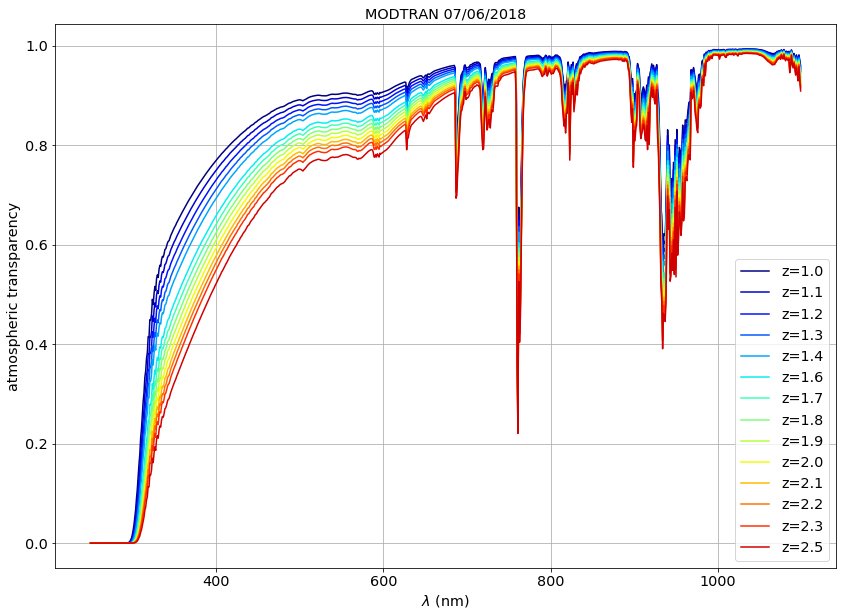

In [370]:
for idx in np.arange(NBMTFILES):    
    colorVal = scalarMap.to_rgba(idx)
    thelabel="z={:2.1f}".format(all_airmasses[idx])
    plt.plot(all_mtdata[idx][:,0],all_mtdata[idx][:,1],color=colorVal,label=thelabel)
plt.grid(True)
plt.title("MODTRAN 07/06/2018")
plt.xlabel("$\lambda$ (nm)")
plt.ylabel("atmospheric transparency")
plt.legend(loc='best')

In [371]:
all_airmasses

[1.0, 1.1, 1.2, 1.3, 1.4, 1.6, 1.7, 1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.5]

# Select One Airmass and One Filter where to do the Comparison

In [372]:
idx_am_sel=4

In [373]:
am=all_airmasses[idx_am_sel]

In [374]:
mtdata_sel=all_mtdata[idx_am_sel]

- In July 18 : Must extend Motran transmission up from 250 nm to 1151 nm


- Afer August/July 18 : Should be [300 - 1050 ]

In [375]:
wl0=mtdata_sel[:,0]
tr0=mtdata_sel[:,1]

In [376]:
wl=np.copy(WL)
tr=np.ones(NBWL)

wl[:len(wl0)]=wl0[:]
tr[:len(tr0)]=tr0[:]


In [377]:
new_wl_indexes=np.where(np.logical_and(wl>=300,wl<1050))

In [378]:
new_wl=wl[new_wl_indexes]
new_tr=tr[new_wl_indexes]

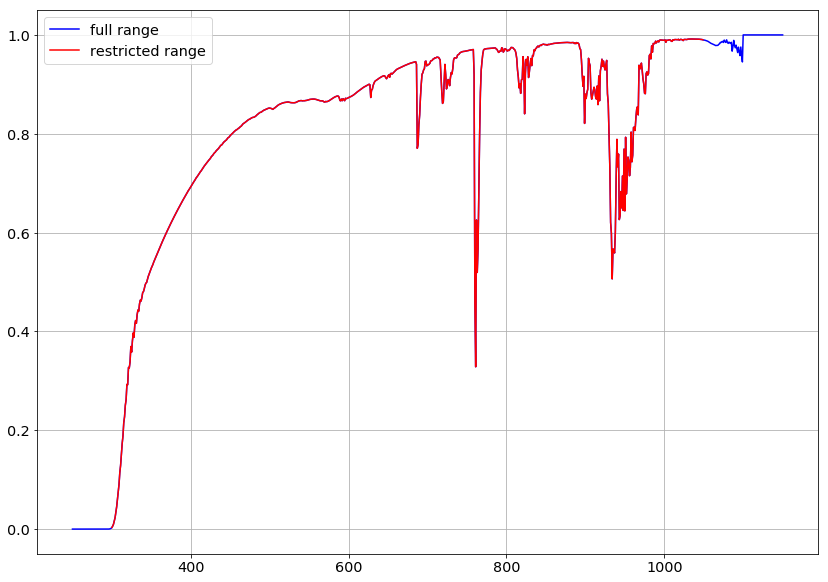

In [379]:
plt.plot(wl,tr,'b-',label='full range')
plt.plot(new_wl,new_tr,'r-',label='restricted range')
plt.legend()
plt.grid()

In [380]:
tel_mt=Telescope()

**** Throughputs.__init__****
System loaded from /sps/lsst/software/lsst_sims/sims_2_7_0/stack/miniconda3-4.3.21-10a4fa6/Linux64/throughputs/2017.01.31-6-g29ce4f5/baseline/
**** Telescope.__init__******


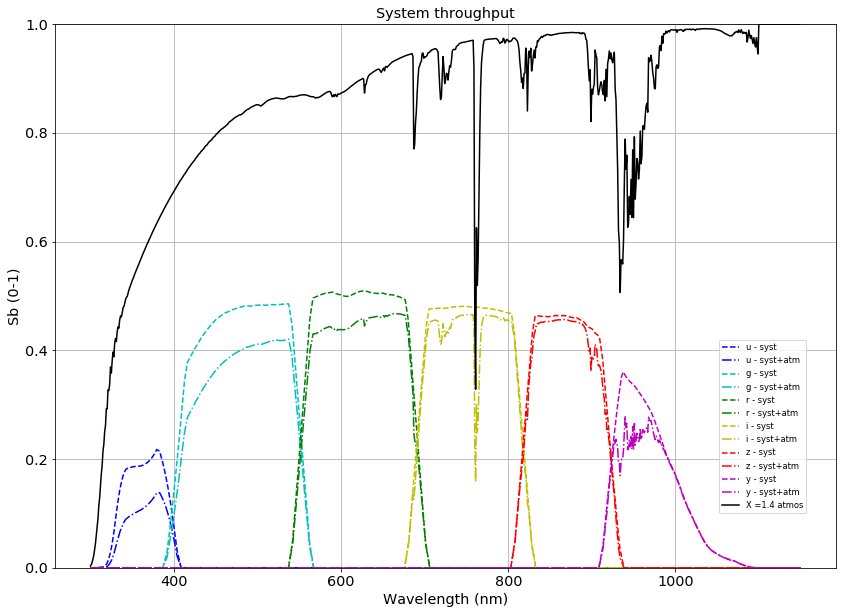

In [381]:
tel_mt.Set_Atmosphere(am,wl,tr)
tel_mt.Plot_Throughputs()

## Tune pwv

In [382]:
all_pwv=np.linspace(4.,6.,20)

In [383]:
NBRTFILES=len(all_pwv)

In [384]:
NBSED_SEL=NBSED_MAX

# Simulate LibRadTran

- at optimum pwv=5 mm

In [385]:

pressure = 782.5
pwv=4.947
aer=0
ozone=300.
wl0=500.
all_pwv=np.array([pwv])
NBRTFILES=len(all_pwv)

In [386]:
all_rtdata=[]
for pwv in all_pwv:
    path,thefile=rt.ProcessSimulationaer(am,pwv,ozone,wl0,aer)
    #path,thefile=rt.ProcessSimulation(am,pwv,ozone)
    data = np.loadtxt(os.path.join(path,thefile))
    all_rtdata.append(data)

--------------------------------------------
 1) airmass =  1.4
 2) pwv =  4.947
 3) oz =  300.0
 4) wl0 =  500.0
 5) tau0 =  0
--------------------------------------------
Running uvspec with input file:  /scratch/dagoret/simulations/RT/2.0.1/LS/pp/us/sa/rt/in/RT_LS_pp_us_sa_rt_z14_wv49_oz30_aer0.INP
Output to file                :  /scratch/dagoret/simulations/RT/2.0.1/LS/pp/us/sa/rt/out/RT_LS_pp_us_sa_rt_z14_wv49_oz30_aer0.OUT
uvspec cmd:  /pbs/throng/lsst/users/dagoret/External/libRadtran/libRadtran-2.0.1/bin/uvspec  < /scratch/dagoret/simulations/RT/2.0.1/LS/pp/us/sa/rt/in/RT_LS_pp_us_sa_rt_z14_wv49_oz30_aer0.INP > /scratch/dagoret/simulations/RT/2.0.1/LS/pp/us/sa/rt/out/RT_LS_pp_us_sa_rt_z14_wv49_oz30_aer0.OUT


In [387]:
jet = cm = plt.get_cmap('jet')
cNorm  = colors.Normalize(vmin=0, vmax=NBRTFILES)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)

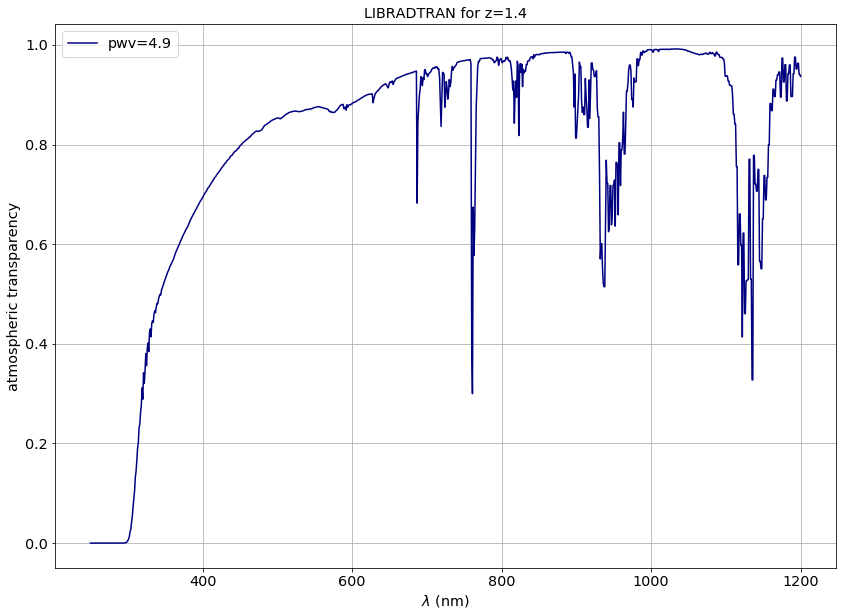

In [388]:
for idx in np.arange(NBRTFILES):    
    colorVal = scalarMap.to_rgba(idx)
    thelabel="pwv={:2.1f}".format(all_pwv[idx])
    plt.plot(all_rtdata[idx][:,0],all_rtdata[idx][:,1],color=colorVal,label=thelabel)
plt.grid(True)
plt.title("LIBRADTRAN for z={:2.1f}".format(am))
plt.xlabel("$\lambda$ (nm)")
plt.ylabel("atmospheric transparency")
plt.legend(loc='upper left')

In [389]:
all_pwv

array([ 4.947])

# LibRadTran Telescope

In [390]:
idx_pwv_sel=0

In [391]:
all_pwv[idx_pwv_sel]

4.9470000000000001

In [392]:
rtdata_sel=all_rtdata[idx_pwv_sel]

In [393]:
tel_rt=Telescope()

**** Throughputs.__init__****
System loaded from /sps/lsst/software/lsst_sims/sims_2_7_0/stack/miniconda3-4.3.21-10a4fa6/Linux64/throughputs/2017.01.31-6-g29ce4f5/baseline/
**** Telescope.__init__******


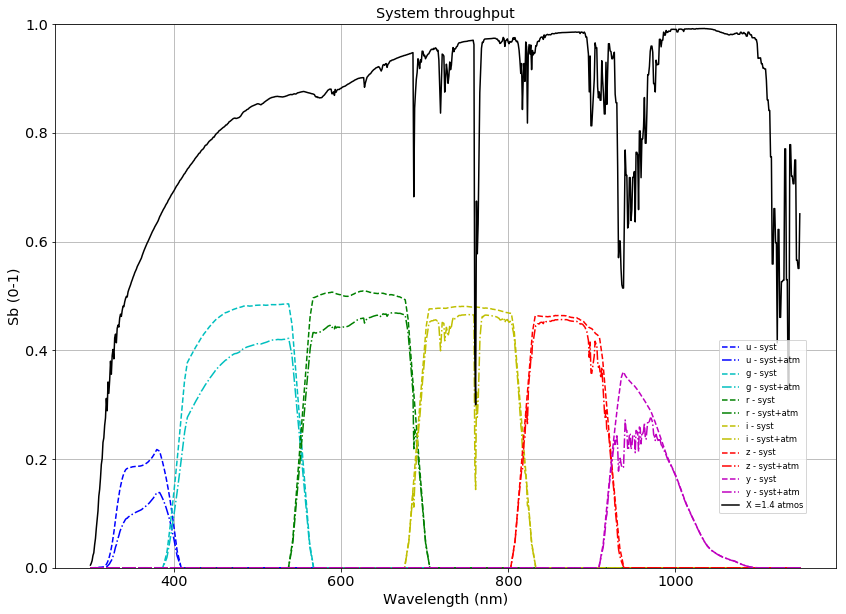

In [394]:
tel_rt.Set_Atmosphere(am,rtdata_sel[:,0],rtdata_sel[:,1])
tel_rt.Plot_Throughputs()

# Extract delta Y vs G-I

## LOOP on SED

In [395]:
filter_tag='y'

In [396]:
def ComputeDeltaMagAndErrorMagAndColor(filter_tag,tel_rt,tel_mt,sed_data):
    
    
    filternum=all_filternum[filter_tag]-1
    skybrightness=LSST_SkyBrightness[filternum]
    FWHMgeom=LSST_GeomSeeing[filternum]
    
    
    # book collections
    all_pulls=np.zeros(NBSED_SEL)
    all_magdelta=np.zeros(NBSED_SEL)
    all_magerr=np.zeros(NBSED_SEL)
    all_color=np.zeros(NBSED_SEL)
    all_abmag=np.zeros(NBSED_SEL)
    
    #print("NBSED_SEL={}".format(NBSED_SEL))
    
    #loop on SED
    for idx_sed in np.arange(NBSED_SEL):
        # extract sed wl and flux
        picklesname='pickles_uvk_{}'.format(idx_sed+1)
        wl_sed=sed_data[0,sidx_spec:]/10.
        flux_sed=sed_data[idx_sed+1,sidx_spec:]*10.
        
        # fill Telescope with that SED
        tel_rt.Set_SED(wavel=wl_sed,newsed=flux_sed,name=picklesname)
        tel_mt.Set_SED(wavel=wl_sed,newsed=flux_sed,name=picklesname)
        
        #compute Instrumental Magnitude
        mag_adu_mt=tel_mt.CalcMyADUMagnitude_filter(filter_tag)
        mag_adu_rt=tel_rt.CalcMyADUMagnitude_filter(filter_tag)
        mag_ab=tel_rt.CalcMyABMagnitude_filter(filter_tag)
        m_g=tel_rt.CalcMyADUMagnitude_filter('g')
        m_i=tel_rt.CalcMyADUMagnitude_filter('i')
        color=m_g-m_i
        
        # compute magnitude error and delta mag
        mag_error=tel_rt.CalcMyABMagnitudesError_filter(filter_tag,skybrightness,FWHMgeom)
        delta_mag= mag_adu_mt-mag_adu_rt
    
        #print('\Delta M = {} \delta m = {} '.format(delta_mag,mag_error))
        
        #fill collection
        all_pulls[idx_sed]=delta_mag/mag_error
        all_magdelta[idx_sed]=delta_mag
        all_magerr[idx_sed]=mag_error
        all_color[idx_sed]=color
        all_abmag[idx_sed]=mag_ab
        
        
        #plt.semilogy(wl_sed,flux_sed)

    return all_magdelta,all_magerr,all_pulls,all_color,all_abmag
        

In [397]:
all_magdelta,all_magerr,all_pulls,all_colors,all_abmag=ComputeDeltaMagAndErrorMagAndColor(filter_tag,tel_rt,tel_mt,sed_data)

(0, 0.2)

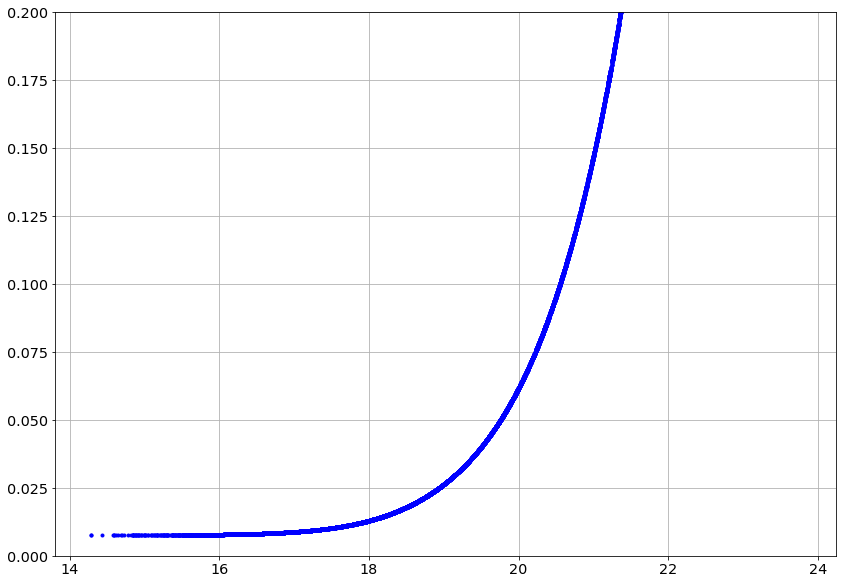

In [398]:
plt.plot(all_abmag,all_magerr,'b.')
plt.grid()
plt.ylim(0,0.2)

In [399]:
MAGCUT=17

In [400]:
selmag_index=np.where(all_abmag<MAGCUT)

In [401]:
all_magdelta2=all_magdelta[selmag_index]
all_colors2=all_colors[selmag_index]
all_magerr2=all_magerr[selmag_index]
all_abmag2=all_abmag[selmag_index]

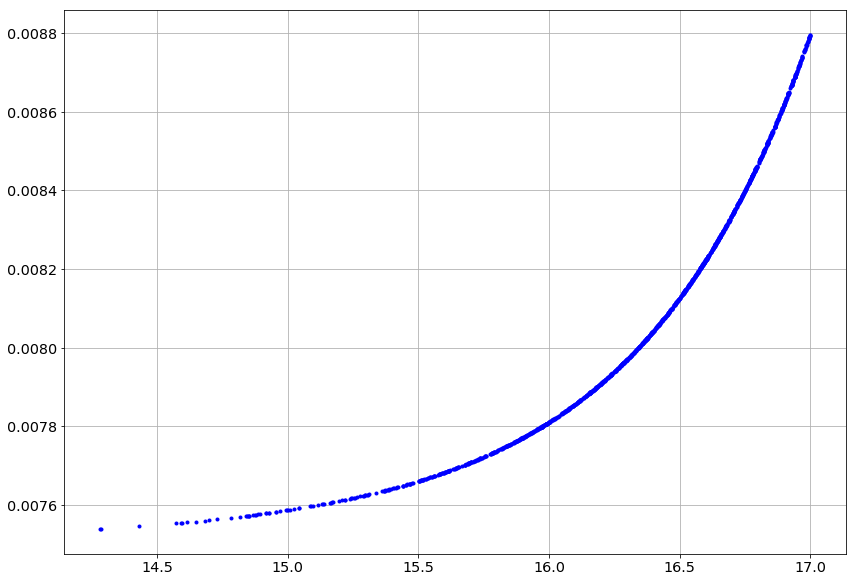

In [402]:
plt.plot(all_abmag2,all_magerr2,'b.')
plt.grid()

# Plot Delta Y vs g-i

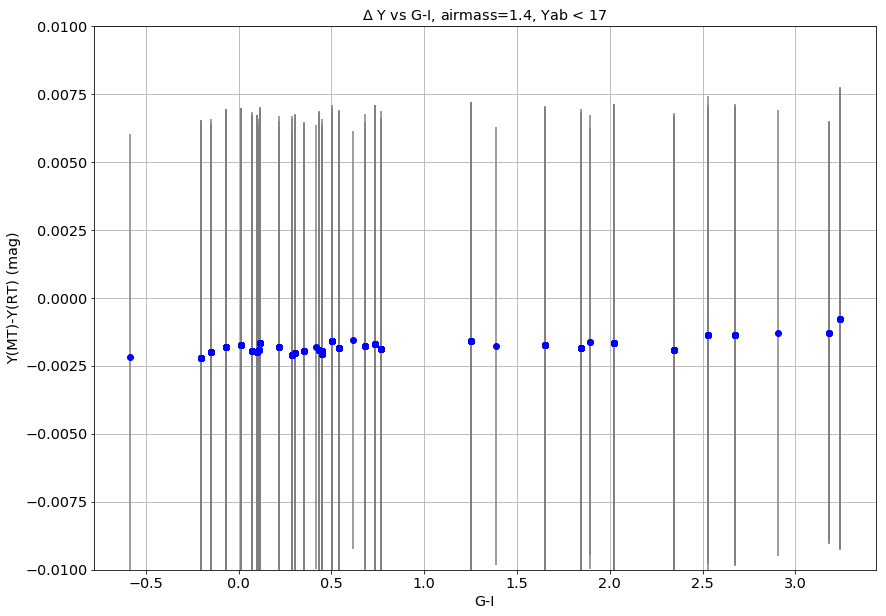

In [403]:
plt.errorbar(all_colors2, all_magdelta2, yerr=all_magerr2, fmt='o',color='b',ecolor='grey', capthick=2) 
plt.grid()
plt.ylim(-0.010,0.01)
plt.xlabel("G-I")
plt.ylabel("Y(MT)-Y(RT) (mag)")
thetitle="$\Delta$ Y vs G-I, airmass={}, Yab < {}".format(am,MAGCUT)
plt.title(thetitle)

# Save file

In [404]:
airmass_num=int(10*am)
am_str=str(airmass_num)
airmass_str=am_str.zfill(2)

In [405]:
airmass_str

'14'

In [406]:
filename_out="dataout_DeltaYvsGmI_z{}.txt".format(airmass_str)
theheader="Delta Y vs color at airmass z= {} Ymag-cut = {} \n".format(am,MAGCUT)
theheader+="color : deltamag : errmag "

In [407]:
data_out=np.zeros((len(all_colors2),3))

In [408]:
data_out[:,0]=np.copy(all_colors2)
data_out[:,1]=np.copy(all_magdelta2)
data_out[:,2]=np.copy(all_magerr2)

In [409]:
np.savetxt(filename_out,data_out,fmt='%3.8f',header=theheader)

In [410]:
filename_out

'dataout_DeltaYvsGmI_z14.txt'

In [411]:
! head $filename_out

# Delta Y vs color at airmass z= 1.4 Ymag-cut = 17 
# color : deltamag : errmag 
1.65104255 -0.00174269 0.00801726
0.73707967 -0.00168281 0.00801258
0.07477107 -0.00193911 0.00847994
1.65104255 -0.00174269 0.00795986
0.01371939 -0.00173127 0.00831946
0.54228686 -0.00182308 0.00788628
2.02097019 -0.00166164 0.00780577
0.09978421 -0.00196840 0.00869244


In [412]:
np.loadtxt(filename_out)

array([[  1.65104255e+00,  -1.74269000e-03,   8.01726000e-03],
       [  7.37079670e-01,  -1.68281000e-03,   8.01258000e-03],
       [  7.47710700e-02,  -1.93911000e-03,   8.47994000e-03],
       ..., 
       [  1.65104255e+00,  -1.74269000e-03,   8.64370000e-03],
       [  1.65104255e+00,  -1.74269000e-03,   7.86888000e-03],
       [  2.02097019e+00,  -1.66164000e-03,   7.90777000e-03]])